In [1]:
import platform

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

In [3]:
import torch
import torch.distributions
import torchvision.transforms as T
from torch import nn
from torch.nn import functional
from torch.utils.data import DataLoader
from torchinfo import summary
from torchvision import datasets
from torchvision.utils import make_grid

## Set Device

In [4]:
def get_device():
    if platform.platform().lower().startswith("mac"):
        return "mps" if torch.backends.mps.is_available() else "cpu"
    else:  # Linux, Windows
        return "cuda" if torch.cuda.is_available() else "cpu"

## Encoder

In [5]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 128, 3, 2, 1),
            nn.BatchNorm2d(128),
            nn.GELU(),
            nn.Conv2d(128, 128, 3, 2, 1),
            nn.BatchNorm2d(128),
            nn.GELU(),
            nn.Conv2d(128, 128, 3, 2, 1),
            nn.BatchNorm2d(128),
            nn.GELU(),
            nn.Conv2d(128, 128, 3, 2, 1),
            nn.BatchNorm2d(128),
            nn.GELU(),
            nn.Flatten(1, -1),
        )
        self.z_mean = nn.Linear(512, 200)
        self.z_log_var = nn.Linear(512, 200)

    def forward(self, x):
        x = self.encoder(x)
        z_mean = self.z_mean(x)
        z_log_var = self.z_log_var(x)
        return z_mean, z_log_var


summary(Encoder(), input_data=torch.rand((8, 1, 28, 28)))

Layer (type:depth-idx)                   Output Shape              Param #
Encoder                                  [8, 200]                  --
├─Sequential: 1-1                        [8, 512]                  --
│    └─Conv2d: 2-1                       [8, 128, 14, 14]          1,280
│    └─BatchNorm2d: 2-2                  [8, 128, 14, 14]          256
│    └─GELU: 2-3                         [8, 128, 14, 14]          --
│    └─Conv2d: 2-4                       [8, 128, 7, 7]            147,584
│    └─BatchNorm2d: 2-5                  [8, 128, 7, 7]            256
│    └─GELU: 2-6                         [8, 128, 7, 7]            --
│    └─Conv2d: 2-7                       [8, 128, 4, 4]            147,584
│    └─BatchNorm2d: 2-8                  [8, 128, 4, 4]            256
│    └─GELU: 2-9                         [8, 128, 4, 4]            --
│    └─Conv2d: 2-10                      [8, 128, 2, 2]            147,584
│    └─BatchNorm2d: 2-11                 [8, 128, 2, 2]         

## Classifier

In [6]:
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        self.classifier = nn.Sequential(nn.Linear(200, 64), nn.Linear(64, 10))

    def forward(self, x):
        return self.classifier(x)

## Sampler

In [7]:
class Sampling(nn.Module):
    def __init__(self):
        super(Sampling, self).__init__()

    def forward(self, x):
        # reparametriztion trick
        z_mean, z_log_var = x
        epsilon = torch.randn_like(z_mean)
        return z_mean + torch.exp(0.5 * z_log_var) * epsilon

## Decoder

In [8]:
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.decoder = nn.Sequential(
            nn.Linear(200, 512),
            nn.GELU(),
            nn.BatchNorm1d(512),
            nn.Unflatten(1, (128, 2, 2)),
            nn.ConvTranspose2d(128, 128, 3, 2, 1, 1),
            nn.BatchNorm2d(128),
            nn.GELU(),
            nn.ConvTranspose2d(128, 128, 3, 2, 1, 0),
            nn.BatchNorm2d(128),
            nn.GELU(),
            nn.ConvTranspose2d(128, 128, 3, 2, 1, 1),
            nn.BatchNorm2d(128),
            nn.GELU(),
            nn.ConvTranspose2d(128, 1, 3, 2, 1, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        return self.decoder(x)


summary(Decoder(), input_data=torch.rand((4, 200)))

Layer (type:depth-idx)                   Output Shape              Param #
Decoder                                  [4, 1, 28, 28]            --
├─Sequential: 1-1                        [4, 1, 28, 28]            --
│    └─Linear: 2-1                       [4, 512]                  102,912
│    └─GELU: 2-2                         [4, 512]                  --
│    └─BatchNorm1d: 2-3                  [4, 512]                  1,024
│    └─Unflatten: 2-4                    [4, 128, 2, 2]            --
│    └─ConvTranspose2d: 2-5              [4, 128, 4, 4]            147,584
│    └─BatchNorm2d: 2-6                  [4, 128, 4, 4]            256
│    └─GELU: 2-7                         [4, 128, 4, 4]            --
│    └─ConvTranspose2d: 2-8              [4, 128, 7, 7]            147,584
│    └─BatchNorm2d: 2-9                  [4, 128, 7, 7]            256
│    └─GELU: 2-10                        [4, 128, 7, 7]            --
│    └─ConvTranspose2d: 2-11             [4, 128, 14, 14]        

## VAE

In [9]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
        self.sampler = Sampling()

    def forward(self, x):
        z_mean, z_log_var = self.encoder(x)
        z = self.sampler((z_mean, z_log_var))
        x_hat = self.decoder(z)
        return z_mean, z_log_var, x_hat


class KLDiv(nn.Module):
    def __init__(self):
        super(KLDiv, self).__init__()

    def forward(self, mean, log_var):
        # Compute the KL divergence
        kl_div = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())
        return kl_div / mean.size(0)

In [10]:
device = get_device()
vae_model = VAE().to(device)
classifier = Classifier().to(device)

In [11]:
optimizer = torch.optim.Adam(vae_model.parameters())
reconstruction_loss = nn.MSELoss()
classifier_loss = nn.CrossEntropyLoss()
kl_divergence = KLDiv()
epochs = 10

mnist_data = datasets.MNIST(".", train=True, download=True, transform=T.ToTensor())
train_loader = DataLoader(mnist_data, batch_size=512, shuffle=True)

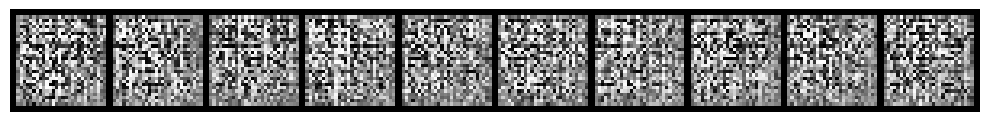

Epoch 1/10: 100%|█████████████| 118/118 [02:01<00:00,  1.03s/it, KL=2.573, Tloss=49.439, rec=0.089, tcl=2.241]


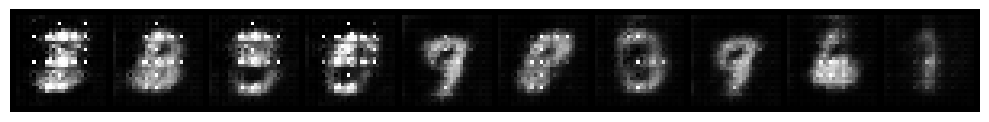

Epoch 2/10: 100%|█████████████| 118/118 [02:46<00:00,  1.41s/it, KL=4.235, Tloss=32.222, rec=0.052, tcl=2.096]


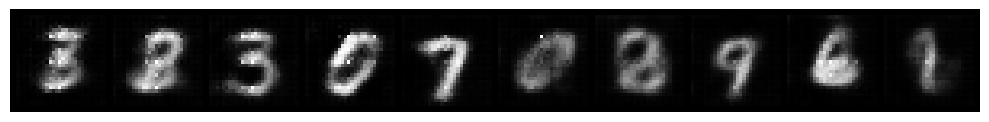

Epoch 3/10: 100%|█████████████| 118/118 [02:48<00:00,  1.43s/it, KL=5.179, Tloss=30.650, rec=0.047, tcl=2.001]


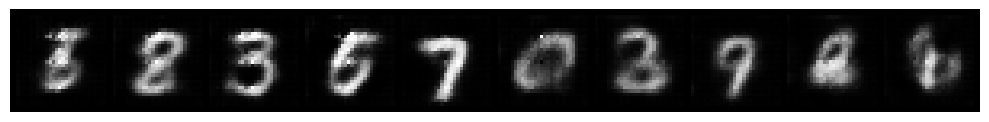

Epoch 4/10: 100%|█████████████| 118/118 [02:50<00:00,  1.44s/it, KL=5.740, Tloss=29.856, rec=0.044, tcl=1.944]


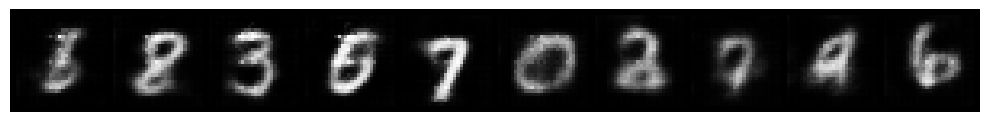

Epoch 5/10: 100%|█████████████| 118/118 [02:05<00:00,  1.07s/it, KL=6.170, Tloss=28.905, rec=0.042, tcl=1.941]


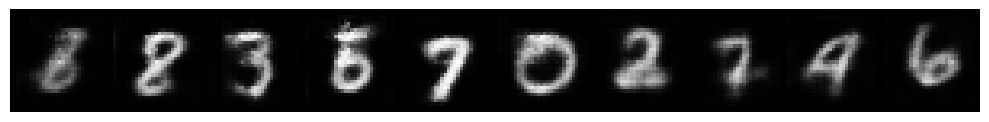

Epoch 6/10: 100%|█████████████| 118/118 [01:55<00:00,  1.02it/s, KL=6.560, Tloss=27.815, rec=0.039, tcl=1.965]


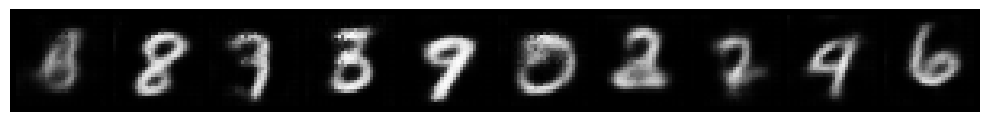

Epoch 7/10: 100%|█████████████| 118/118 [01:57<00:00,  1.01it/s, KL=6.830, Tloss=26.871, rec=0.036, tcl=1.996]


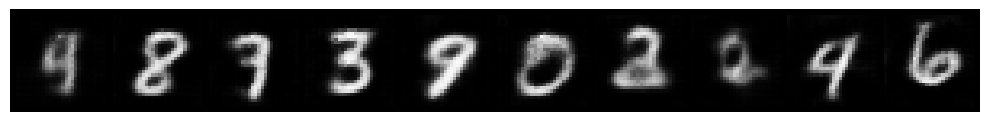

Epoch 8/10: 100%|█████████████| 118/118 [01:58<00:00,  1.01s/it, KL=7.067, Tloss=26.109, rec=0.034, tcl=2.025]


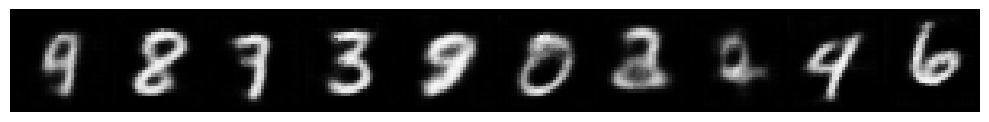

Epoch 9/10: 100%|█████████████| 118/118 [02:02<00:00,  1.04s/it, KL=7.272, Tloss=25.690, rec=0.033, tcl=2.038]


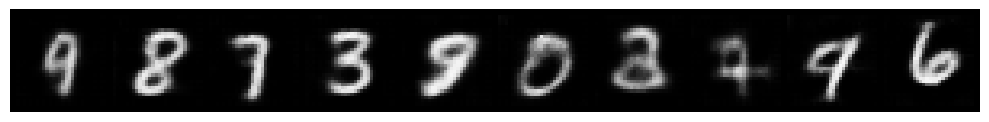

Epoch 10/10: 100%|████████████| 118/118 [01:57<00:00,  1.00it/s, KL=7.457, Tloss=25.306, rec=0.032, tcl=2.050]


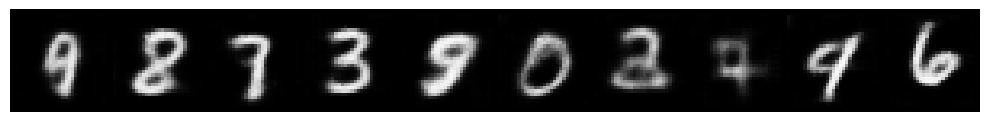

In [12]:
loss_tracker = []
vae_model.train()
N = len(train_loader.dataset)
fixed_z = torch.randn(10, 200).to(device)
with torch.no_grad():
    x_hat = vae_model.decoder(fixed_z)
x_hat_grid = make_grid(x_hat, nrow=10)
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.imshow(x_hat_grid.cpu().permute(1, 2, 0))
ax.axis("off")
plt.tight_layout()
plt.show()
for epoch in range(epochs):
    t_loss = 0
    trec = 0
    tkl = 0
    tcl = 0
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", leave=True)
    for image, label in pbar:
        image = image.to(device)
        label = label.to(device)
        z_mean, z_log_var, x_hat = vae_model(image)
        mean_class = classifier(z_mean)
        class_loss = classifier_loss(mean_class, label)
        rec_loss = reconstruction_loss(image, x_hat)
        kl_div = kl_divergence(z_mean, z_log_var)
        loss = 500* rec_loss + kl_div + class_loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        trec += rec_loss.item() * image.size(0)
        tkl += kl_div.item() * image.size(0)
        tcl += class_loss * image.size(0)
        t_loss += loss.item() * image.size(0)
        pbar.set_postfix(
            Tloss=f"{t_loss/N:.3f}",
            rec=f"{trec/N:.3f}",
            KL=f"{tkl/N:.3f}",
            tcl=f"{tcl/N:.3f}",
        )
    t_loss = t_loss / N
    loss_tracker.append(t_loss)
    with torch.no_grad():
        x_hat = vae_model.decoder(fixed_z)
    x_hat_grid = make_grid(x_hat, nrow=10)
    fig, ax = plt.subplots(1, 1, figsize=(10, 5))
    ax.imshow(x_hat_grid.cpu().permute(1, 2, 0))
    ax.axis("off")
    plt.tight_layout()
    plt.show()

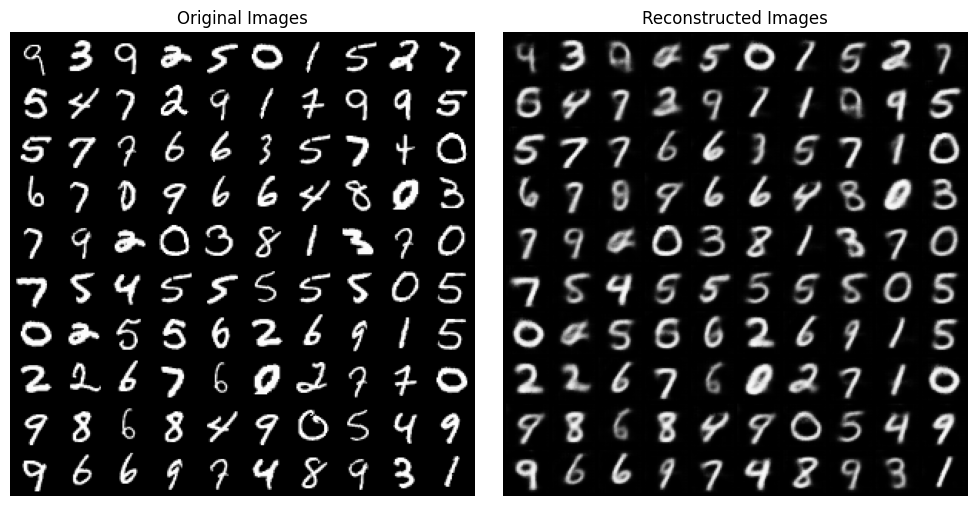

In [16]:
with torch.no_grad():
    image = image.to(device)
    label = label.to(device)
    z_mean, z_log_var, x_hat = vae_model(image)

indices = torch.randint(0, x_hat.size(0), (100,))
x_hat_subset = x_hat[indices]
x = image[indices]

x_grid = make_grid(x, nrow=10)
x_hat_grid = make_grid(x_hat_subset, nrow=10)

# Plot the grids
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].imshow(x_grid.cpu().permute(1, 2, 0))
axes[0].set_title("Original Images")
axes[0].axis("off")

axes[1].imshow(x_hat_grid.cpu().permute(1, 2, 0))
axes[1].set_title("Reconstructed Images")
axes[1].axis("off")

plt.tight_layout()
plt.show()

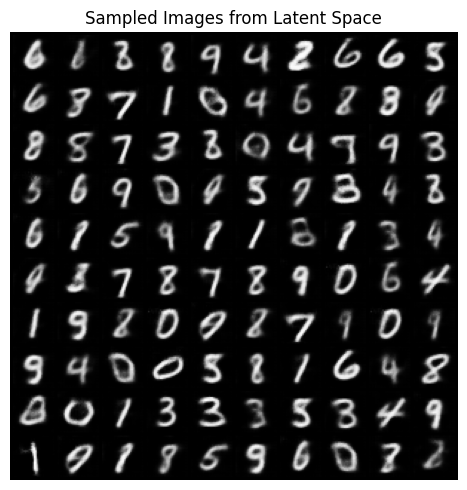

In [17]:
with torch.no_grad():
    z = torch.randn(100, 200).to(device)
    x_hat = vae_model.decoder(z)
    indices = torch.randint(0, x_hat.size(0), (100,))
    x_hat_subset = x_hat[indices]

x_hat_grid = make_grid(x_hat_subset, nrow=10)
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.imshow(x_hat_grid.cpu().permute(1, 2, 0))
ax.set_title("Sampled Images from Latent Space")
ax.axis("off")

plt.tight_layout()
plt.show()

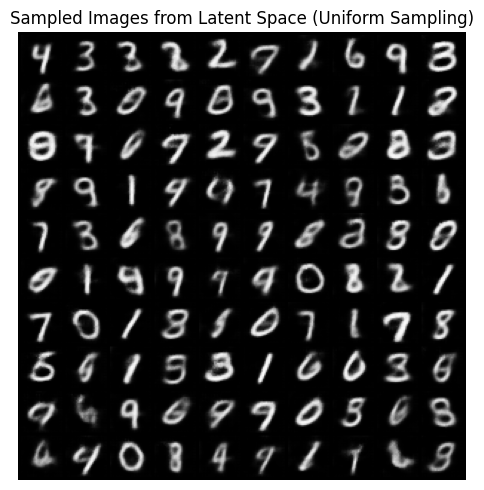

In [20]:
with torch.no_grad():
    latent_range = (-10, 10)
    z = torch.rand(100, 200) * (latent_range[1] - latent_range[0]) + latent_range[0]
    z = z.to(device)
    x_hat = vae_model.decoder(z)
x_hat_grid = make_grid(x_hat, nrow=10)

fig, ax = plt.subplots(1, 1, figsize=(10, 5))

ax.imshow(x_hat_grid.cpu().permute(1, 2, 0))
ax.set_title("Sampled Images from Latent Space (Uniform Sampling)")
ax.axis("off")

plt.tight_layout()
plt.show()